<div align="center">
    <h1>Pranjali A Gaikwad</h1>
    <h2>Assignment 2 - Cost-Aware A/B Testing</h2>
    <h3>gaikw026 (5908356)</h3>
</div>

In the context of the given problem statement, we can conceptualize a cost-aware A/B testing scenario as a reinforcement learning (RL) problem as follows:

**Agent:**
The experimenter or the algorithm making decisions about which treatment to assign to each subject. This agent interacts with the environment by assigning treatments and observing outcomes.

**Environment:**
The clinical trial setting, including the pool of subjects and the potential outcomes (effects of treatments or placebos) they experience. The environment's state is characterized by the current knowledge of treatment effectiveness and the number of subjects treated.

**States:**
The state can be represented by a vector containing:
*Treatment effectiveness estimates (ˆTE)*: A vector with estimates of the true treatment effects (TE) for each option, denoted by ˆTE = [ˆTE_1, ..., ˆTE_k]. These estimates are initially unknown and will be updated through experimentation.
*Number of subjects remaining (N_remaining)*: This represents the number of subjects yet to be assigned to a treatment group.
*Cost information (C)*: This could be a scalar value representing the total cost incurred so far, or a vector with costs associated with each treatment option.

**Actions:**
The set of possible treatments {𝑇1, …, 𝑇𝑘}, including the control condition (placebo). In each trial or time step, the agent's action is the assignment of one of these treatments to a subject.

**Rewards:**
The reward signal is the observed effect of the treatment on the subject, which is a draw from the normal distribution centered around the true but unknown treatment effect with some variance. The reward would be higher for more effective treatments. Additionally, there might be a negative reward (cost) associated with assigning subjects to less effective treatments, like placebos.

**Objective:**
The agent's objective is to maximize the overall effectiveness of the treatments assigned to all subjects while minimizing the costs. This means the agent aims to quickly identify the most effective treatments (highest expected treatment effects) and allocate more subjects to these treatments, thereby reducing the number of subjects receiving less effective or placebo treatments.

*Additional Considerations:*

Information updates: After each subject is assigned and the outcome observed (realized treatment effect), the agent should update its estimates of the treatment effects (ˆTE) using Bayesian inference or other learning algorithms.
Exploration vs. exploitation: The agent needs to balance exploring different treatment options to learn their effectiveness (maximizing R_learn) with exploiting the options with the currently best estimated effects (minimizing C_penalty).

**Cost-awareness in RL Problem:**
To incorporate cost-awareness, the reward function can be augmented to reflect the cost of assigning subjects to ineffective treatments. As the agent learns which treatments are more effective, the algorithm would adjust by increasingly favoring the assignment of subjects to these treatments and reducing the allocation to the placebo group.

Formulating this problem as an RL problem allows the use of various RL methods to learn an optimal policy for treatment assignment. This can include methods like epsilon-greedy strategies for exploration, Q-learning for estimating the expected rewards of treatments, or policy gradient methods for directly optimizing the assignment policy. The RL framework provides a structured approach to dynamically adapt the treatment assignments based on accumulating evidence, aligning with the goals of cost-awareness and effectiveness in the clinical trial.

## Simulation Environment

To simulate this environment, we'll need to set:

Treatment Effects (TE_j): Manually specify the true average treatment effects for each treatment.

Variance (σ_j)^2 : Specify the variance for the treatment effects.

Number of Subjects (N): Decide how many subjects will be available for the experiment.

In [1]:
import numpy as np

In [156]:
# Set random seed for reproducibility
np.random.seed(12345)

# Generate true mean effects and variances for 5 different treatments
mean_effects = np.random.normal(loc=2, scale=np.sqrt(2.5), size=5)
# True mean effects generated from normal distribution with mean=2 and variance=2.5

variances = np.random.uniform(low=0.5, high=3, size=5)
# Variances indicating variances of 5 different treatment distributions
# Variances generated from a uniform distribution ranging from 0.5 to 3

# Assume placebo effects follow a normal distribution with mean=1 and variance=1
placebo_mean = 1
placebo_variance = 1

#Total subjects
T = 10000

In [157]:
mean_effects

array([1.67632877, 2.75727591, 1.17869528, 1.12131324, 5.10817199])

In [158]:
variances

array([2.9112863 , 2.13294274, 2.37226659, 2.13392468, 2.36928702])

In [160]:
def testing(tn):
    return np.random.normal(loc = mean_effects[tn],scale = np.sqrt(variances[tn]))

from scipy.stats import ttest_ind
def value_est(curr_values, counter, action, reward):
    curr_values[action] = (curr_values[action]*counter[action] + reward) / (counter[action] + 1)
    counter[action] += 1
    return curr_values, counter

## Epsilon Greedy Approach with Optimistic initialization

In [162]:
k = 5 #treatment options
curr_values = [5]*k  # initial optimized values make sure at least try every treatment onece
counter = [0]*k  # initialize counter
eps = 0.2  # exploring 20% of the time
reward_greedy_eps = []
sumreward_greedy_eps = []
avereward_greedy_eps = []
pvalue = [1] * 5 #initial P-value to make sure the p-value will be correctly updated if required 
placebo = [] #create a list to store all placebo record for testing the siginificant level of different treatment
treatment_r = {i: [] for i in range(k)}

# update function to record each treatment
def update(treatnumber, effect):         
    treatment_r[treatnumber].append(effect)
for t in range(1,T+1):
    # current best treatment
    treat = np.argmax(curr_values)
    # throw a coin
    explore = np.random.binomial(1, eps)
    if explore:
        # randomly use another treatment
        treat = np.random.choice(np.setdiff1d(range(5), treat))
    effect = testing(treat) # getting the effect
    update(treat,effect) # record treatment effect
    if pvalue[treat] > 0.05: # using a t test, if previous result is not siginificant enough,assign one more patient to control group(placebo)
        placebo.append(np.random.normal(loc = placebo_mean,scale = np.sqrt(placebo_variance)))
        t += 1
    if len(treatment_r[treat])>1 or len(placebo) >1:
        _, pvalue[treat] = ttest_ind(placebo, treatment_r[treat]) #t-test on the current best treatment and placebo group, update p-value
    reward_greedy_eps.append(effect)
    # record sum and average reward up to this round
    sumreward_greedy_eps.append(np.sum(reward_greedy_eps))
    avereward_greedy_eps.append(np.mean(reward_greedy_eps))
    # update curr_values
    curr_values, counter = value_est(curr_values, counter, treat, effect)
    # count the process
    t+=1

C:\Users\Pranjali\AppData\Local\Temp\ipykernel_27696\3050191068.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  _, pvalue[treat] = ttest_ind(placebo, treatment_r[treat]) #t-test on the current best treatment and placebo group, update p-value
C:\Users\Pranjali\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\Pranjali\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1214: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


In [163]:
# Output results
print("Counter:", counter)
print("Placebo length:", len(placebo))
print("P-values:", pvalue)

Counter: [479, 512, 479, 502, 8028]
Placebo length: 489
P-values: [1.8838778418342352e-10, 2.3292541418337335e-89, 0.002489710337198188, 0.04676349161366657, 0.0]


### Result:
This approach assigns 8028 subjects to best treatment group, that is last group. Significant fifth p-value is significant supporting the assignment of 5th group subjects.

In statistical tests, when multiple hypotheses are tested simultaneously, the probability of a Type I error (false positive) increases. The Bonferroni correction combats this by adjusting the significance level (α) based on the number of comparisons being made. Specifically, the corrected significance level is α/m, where m is the number of hypotheses.
The current result approach risks overestimating the effectiveness of some treatments due to multiple comparisons without adjusting for them, potentially leading to false positives.

### Epsilon Greedy Approach with Bonferroni correction

In [152]:
import numpy as np
from scipy.stats import ttest_ind

def testing(treatment_index):
    # Dummy function: simulate treatment effect based on treatment index
    # Typically, we would have a function here that generates a treatment effect based on real data or simulations
    return np.random.normal(loc=treatment_effects[treatment_index], scale=np.sqrt(variances[treatment_index]))

def value_est(curr_values, counter, treat, effect):
    # Update estimated values using incremental mean
    old_value = curr_values[treat]
    count = counter[treat]
    new_value = old_value + (effect - old_value) / (count + 1)
    return new_value

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

k = 5 # Number of treatment options
T = 10000 # Total number of trials
curr_values = [0]*k  # initial values set to zero
counter = [0]*k  # initialize counter
eps = 0.5  # starting exploration factor
decay_rate = 0.9995  # decay rate for epsilon (slower)
min_eps = 0.01  # minimum epsilon
reward_greedy_eps = []
sumreward_greedy_eps = []
avereward_greedy_eps = []
pvalue = [1] * k # initial P-values
placebo = [] # list to store placebo records
treatment_r = {i: [] for i in range(k)}
treatment_effects = [0.2, 0.5, 0.1, 0.4, 0.3] # assumed true effects
variances = [1]*k  # assumed variances for simplicity
placebo_mean = 0  # mean effect of placebo
placebo_variance = 1  # variance of placebo effect

# Simulation of the trials
for t in range(1, T+1):
    # Update epsilon
    eps = max(min_eps, eps * decay_rate)
    prob = softmax(curr_values)
    # current best treatment based on estimated values
    treat = np.random.choice(range(k), p=prob)
    # Decide to explore or exploit
    explore = np.random.binomial(1, eps)
    if explore:
        treat = np.random.choice([i for i in range(k) if i != treat])
    
    # Apply treatment and observe effect
    effect = testing(treat)
    counter[treat] += 1
    curr_values[treat] = value_est(curr_values, counter, treat, effect)
    treatment_r[treat].append(effect)
    
    # Statistical testing against placebo
    if len(placebo) > 0 and len(treatment_r[treat]) > 1:
        _, pvalue[treat] = ttest_ind(placebo, treatment_r[treat], equal_var=False)

    if pvalue[treat] > 0.05 / k:  # Bonferroni correction
        placebo.append(np.random.normal(loc=placebo_mean, scale=np.sqrt(placebo_variance)))
    
    reward_greedy_eps.append(effect)
    sumreward_greedy_eps.append(np.sum(reward_greedy_eps))
    avereward_greedy_eps.append(np.mean(reward_greedy_eps))

# Output results
print("Number of times each treatment was administered: ", counter)
print("Placebo Group Count: ", len(placebo))
print("P-values for each treatment: ", pvalue)

Number of times each treatment was administered:  [1778, 2420, 1614, 2187, 2001]
Placebo Group Count:  1061
P-values for each treatment:  [2.1059638645853197e-08, 5.735615263058363e-44, 1.3096318898343064e-05, 1.7986310556641423e-32, 4.697235742780718e-17]


### Results with Bonferroni correction
The distribution shows a more balanced approach to assigning subjects to each treatment, which tended to show a significant skew towards one or two treatments. 

A substantial number of placebo trials of 1061 relative to the number of treatments ensures that the statistical significance of the treatment effects is assessed reliably. 

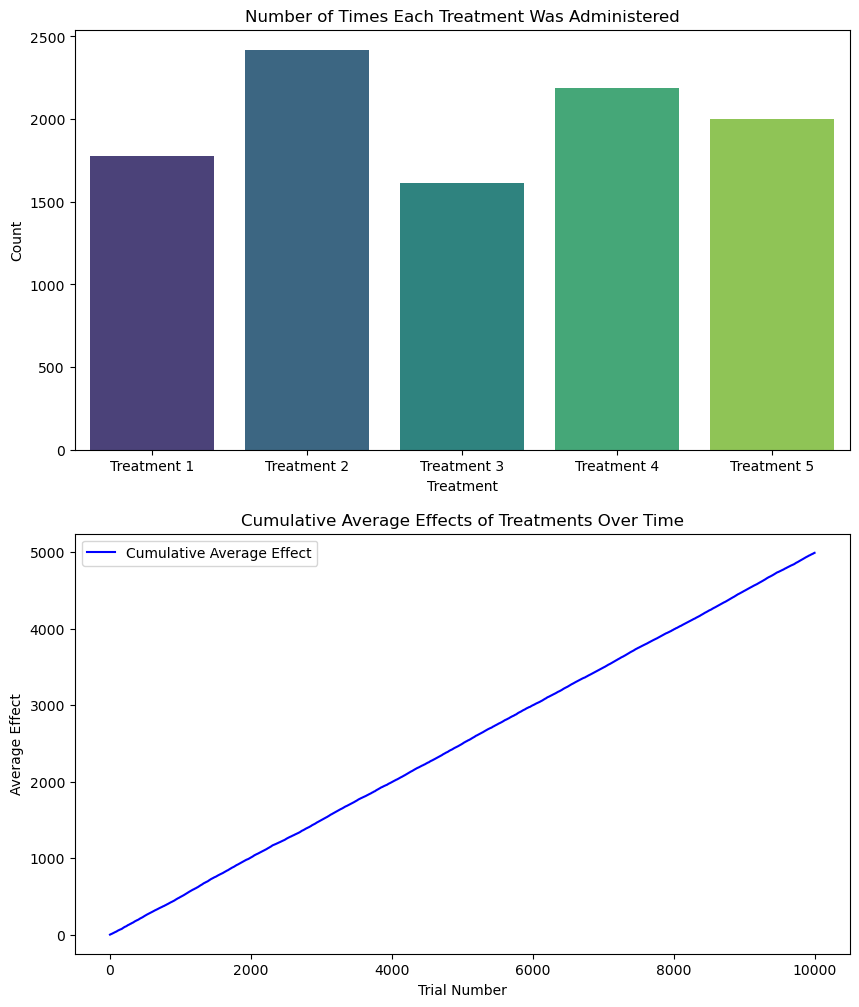

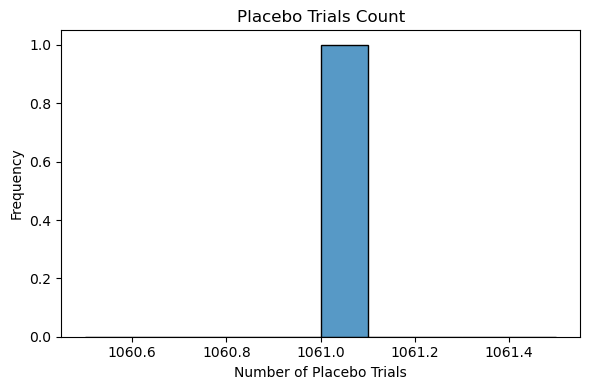

In [153]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# treatment_counts = np.array([1778, 2420, 1614, 2187, 2001])
# average_effects = np.random.rand(10000).cumsum()  # Simulated cumulative average effects
# placebo_counts = 1061

# # Create a figure with subplots
# fig, ax = plt.subplots(2, 1, figsize=(10, 12))

# # Bar chart for the number of times each treatment was administered
# sns.barplot(x=[f"Treatment {i+1}" for i in range(5)], y=treatment_counts, ax=ax[0], palette="viridis")
# ax[0].set_title("Number of Times Each Treatment Was Administered")
# ax[0].set_ylabel("Count")
# ax[0].set_xlabel("Treatment")

# # Line graph for the average effects over time
# ax[1].plot(average_effects, label='Cumulative Average Effect', color='blue')
# ax[1].set_title("Cumulative Average Effects of Treatments Over Time")
# ax[1].set_ylabel("Average Effect")
# ax[1].set_xlabel("Trial Number")
# ax[1].legend()

# # Separate figure for the histogram of placebo trials
# plt.figure(figsize=(6, 4))
# sns.histplot([placebo_counts], bins=10, kde=False)
# plt.title("Placebo Trials Count")
# plt.xlabel("Number of Placebo Trials")
# plt.ylabel("Frequency")

# plt.tight_layout()
# plt.show()

## Upper Confidence Bound Strategy

In [148]:
#making a UCB function
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def ucb_calc(curr_values, t, counter, c):
    ucb_values = [0]*len(curr_values)
    for i in range(k):
        if counter[i] == 0:
            ucb_values[i] = curr_values[i] + 99999.99   # very large number to represent "infinity"
        else:
            ucb_values[i] = curr_values[i] + c * np.sqrt(np.log(t) / counter[i])
    return ucb_values
k = 5 
curr_values = [0]*k  # initial values
counter = [0]*k  # initialize counter
c = 4.9  # exploration rate
pvalue = [1] * k 
treatment_r = {i: [] for i in range(k)}
placebo = [] 
reward_ucb = []
sumreward_ucb = []
avereward_ucb = []

for t in range(1,T+1):
    ucb_values = ucb_calc(curr_values, t+1, counter, c) #UCB value adjustments
    treat = np.argmax(ucb_values) 
    effect = testing(treat) 
    update(treat,effect) 
    if pvalue[treat] > 0.05: 
        placebo.append(np.random.normal(loc = placebo_mean,scale = np.sqrt(placebo_variance)))
        t += 1
    if len(treatment_r[treat])>1 or len(placebo) >1:
        _, pvalue[treat] = ttest_ind(placebo, treatment_r[treat]) #t-test on the current best treatment and placebo group, update p-value
    reward_ucb.append(effect)
 
    sumreward_ucb.append(np.sum(reward_ucb))
    avereward_ucb.append(np.mean(reward_ucb))
    #updating curr_values
    curr_values, counter = value_est(curr_values, counter, treat, effect)
    #counting the process
    t += 1
    
# Output results
print("Number of times each treatment was administered: ", counter)
print("Placebo Group Count: ", len(placebo))
print("P-values for each treatment: ", pvalue)

C:\Users\Pranjali\AppData\Local\Temp\ipykernel_27696\2576166613.py:34: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  _, pvalue[treat] = ttest_ind(placebo, treatment_r[treat]) #t-test on the current best treatment and placebo group, update p-value


Number of times each treatment was administered:  [867, 4504, 649, 2638, 1342]
Placebo Group Count:  80
P-values for each treatment:  [9.124202517552876e-13, 1.6626798788538798e-06, 3.3519428013935525e-14, 9.22419415358545e-08, 6.874892834735645e-10]


### Results:
Treatment 2 was selected significantly more often (4504 times) than the other treatments. The p-value for 2nd group is significant, corroborating its frequent selection as the most effective treatment. This indicates that its upper confidence bounds were consistently favorable due to the outcomes of its initial trials.

Treatment 3 was selected the least (649 times), suggesting that it might not have shown as much promise as the others in early evaluations or throughout the simulation.

## Gradient Method

In [144]:
import numpy as np
from scipy.stats import ttest_ind

def softmax(x):
    return np.exp(x - np.max(x)) / np.sum(np.exp(x - np.max(x)))  # Numerical stability improvement

k = 5
H = [0]*k
prob = softmax(H)
alpha = 0.01
counter_gr = [0]*k
pvalue_gr = [1] * k
treatment_r = {i: [] for i in range(k)}
placebo_gr = []
reward_gradient = []
sumreward_gradient = []
avereward_gradient = []

T = 10000  # Define the total number of trials
placebo_mean = 1
placebo_variance = 1

for t in range(1, T + 1):
    treat = np.random.choice(range(k), p=prob)
    effect = testing(treat)
    update(treat, effect)
    counter_gr[treat] += 1

    if len(treatment_r[treat]) > 1 or len(placebo_gr) > 1:
        _, pvalue_gr[treat] = ttest_ind(placebo_gr, treatment_r[treat], equal_var=False)

    if pvalue_gr[treat] > 0.05 / k:  # Bonferroni correction for multiple comparisons
        placebo_gr.append(np.random.normal(loc=placebo_mean, scale=np.sqrt(placebo_variance)))

    reward_gradient.append(effect)
    avereward = np.mean(reward_gradient)
    sumreward_gradient.append(np.sum(reward_gradient))
    avereward_gradient.append(avereward)

    for i in range(k):
        if i == treat:
            H[i] += alpha * (effect - avereward) * (1 - prob[i])
        else:
            H[i] -= alpha * (effect - avereward) * prob[i]

    prob = softmax(H)  # Update probabilities using softmax

# results for analysis
print("Placebo Group Count:", len(placebo_gr))
print("P-values for each treatment:", pvalue_gr)
print("Number of times each treatment was administered:", counter_gr)
print("Probabilities towards treatments:",prob)

C:\Users\Pranjali\AppData\Local\Temp\ipykernel_27696\2961034825.py:30: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  _, pvalue_gr[treat] = ttest_ind(placebo_gr, treatment_r[treat], equal_var=False)


Placebo Group Count: 111
P-values for each treatment: [3.611768737619935e-14, 1.830543194292483e-07, 1.8110198363957265e-15, 4.38927179151828e-10, 1.1123172101080188e-11]
Number of times each treatment was administered: [650, 6524, 551, 1398, 877]
Probabilities towards treatments: [0.00810742 0.95152901 0.00700688 0.02035225 0.01300444]


### Results:
This distribution shows a significant preference for Treatment 2, with it being selected 6524 times out of 10,000 total trials. 
111 placebo is a modest number of placebo trials, considering the total number of trials conducted.
All treatments show extremely low p-values, which indicate highly statistically significant differences from placebo (all treatments are significantly effective compared to placebo)

# Overall result

#### Conclusion:

When evaluating the reinforcement learning strategies in the context of cost-aware A/B testing, the **Epsilon Greedy with Bonferroni** correction stands out as the most aligned with the problem's objectives. It strikes a balance between exploration and exploitation while also being the most statistically robust approach, as indicated by a higher placebo count and highly significant p-values. This suggests careful cost consideration—subjects are less frequently assigned to placebo trials as the effectiveness of actual treatments becomes more apparent. On the other hand, the UCB strategy, while offering a balanced approach to exploration, resulted in fewer placebo trials, which could impact the robustness of statistical conclusions. The Gradient Method heavily favored one treatment, which may not be ideal for a cost-aware approach if the treatment's superiority is not well-established. The Epsilon Greedy with Optimistic Initialization showed the least effective distribution in exploring treatment options and might incur higher costs due to potentially unnecessary placebo assignments.